In [4]:
import numpy as np
import pandas as pd
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import time
import re
from tensorflow.python.client import device_lib

import mlflow
import tensorflow as tf
from mlflow.models import infer_signature
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
import shap

In [5]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [6]:
df = pd.read_csv("dataframe_final.csv")

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [7]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


In [8]:
# To start the mlflow server in local : mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("OCR_Project7")

2024/02/01 16:02:15 INFO mlflow.tracking.fluent: Experiment with name 'OCR_Project7' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/660074711239750018', creation_time=1706799735679, experiment_id='660074711239750018', last_update_time=1706799735679, lifecycle_stage='active', name='OCR_Project7', tags={}>

In [9]:
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

In [10]:
def custom_score_func(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    FN = cf_matrix[1,0]
    FP = cf_matrix[0,1]

    return 10*FN+FP

In [14]:
def calcul_metrics(model, X, y):
    """Fonction de calcul des metriques précision, AUC et score_metier en fonction du modèle en entrée. Retourne un dictionnaire."""
    metrics = {}
    
    accuracy = model.score(X, y)
    print(f'Précision : {accuracy:.2f}')
    metrics['accuracy'] = accuracy
    
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'AUC : {roc_auc:.2f}')
    metrics['roc_auc'] = roc_auc

    #cf_matrix = confusion_matrix(y, model.predict(X))
    #FN = cf_matrix[1,0]
    #FP = cf_matrix[0,1]
    score_metier = custom_score_func(y, model.predict(X))
    print(f'Score métier : {score_metier}')
    metrics['score_metier'] = score_metier

    return metrics
    

In [19]:
def logToMLflow(model, X, eval_data, metrics, name="", params="", training_tag=""):
    # Start an MLflow run
    with mlflow.start_run(run_name=name):
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)

        # Log the loss metric
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])
        mlflow.log_metric("score_metier", metrics['score_metier'])
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)
    
        # Infer the model signature
        signature = infer_signature(X, model.predict(X))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(model, 'model', signature=signature)

        result = mlflow.evaluate(
            model_info.model_uri,
            eval_data,
            targets="TARGET",
            model_type="classifier",
            evaluators=["default"],
        )

In [13]:
#Fonction prise dans le cours pour afficher les résultats d'un GridSearch.

def resultizeGrid(grid):
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    
    return res

# LOGISTIC REGRESSION

In [17]:
sorted(train_df.columns.tolist())

['ACTIVE_AMT_ANNUITY_MAX',
 'ACTIVE_AMT_ANNUITY_MEAN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_CNT_CREDIT_PROLONG_SUM',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_MIN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_VAR',
 'ACTIVE_MONTHS_BALANCE_MAX_MAX',
 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
 'ACTIVE_MONTHS_BALANCE_SIZE_SUM',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'A

In [16]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

train_x, valid_x, train_y, valid_y = train_test_split(train_df[feats], train_df['TARGET'], test_size=0.15, random_state=0)

In [17]:
col = train_x.columns

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

train_x = pd.DataFrame(train_x, columns=col)
valid_x = pd.DataFrame(valid_x, columns=col)

## Without SMOTE

Gestion des valeurs manquantes.

In [21]:
%%time

lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

metrics = calcul_metrics(lr, valid_x, valid_y)
print(classification_report(valid_y, lr.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(lr, train_x, val_data, metrics, name="LogReg_noSmote_noParam", training_tag="Basic LR model no SMOTE no param")

Précision : 0.92
AUC : 0.53
Score métier : 36756
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.08      0.00      0.00      3675

    accuracy                           0.92     46127
   macro avg       0.50      0.50      0.48     46127
weighted avg       0.85      0.92      0.88     46127



2024/02/01 16:11:45 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/01 16:11:45 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/01 16:11:48 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
2024/02/01 16:11:48 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


CPU times: total: 2min 8s
Wall time: 25 s


In [26]:
cf_matrix = confusion_matrix(valid_y, lr.predict(valid_x))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

<Axes: >

## Features Importances

### Native coef function

In [32]:
plt.figure(figsize=(15,6))
color_list =  sns.color_palette("dark", len(train_df.columns)) 
top_x = 10
logistic_reg_coeff = lr.coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(train_df.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

### SHAP

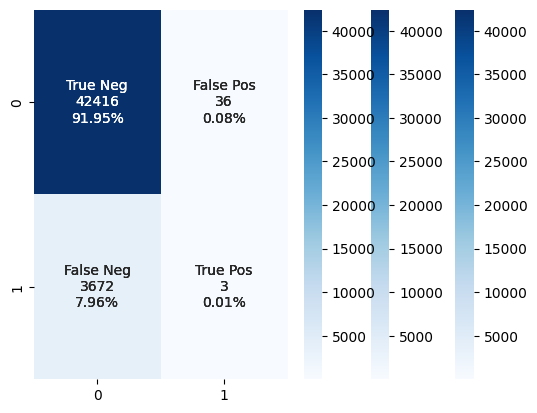

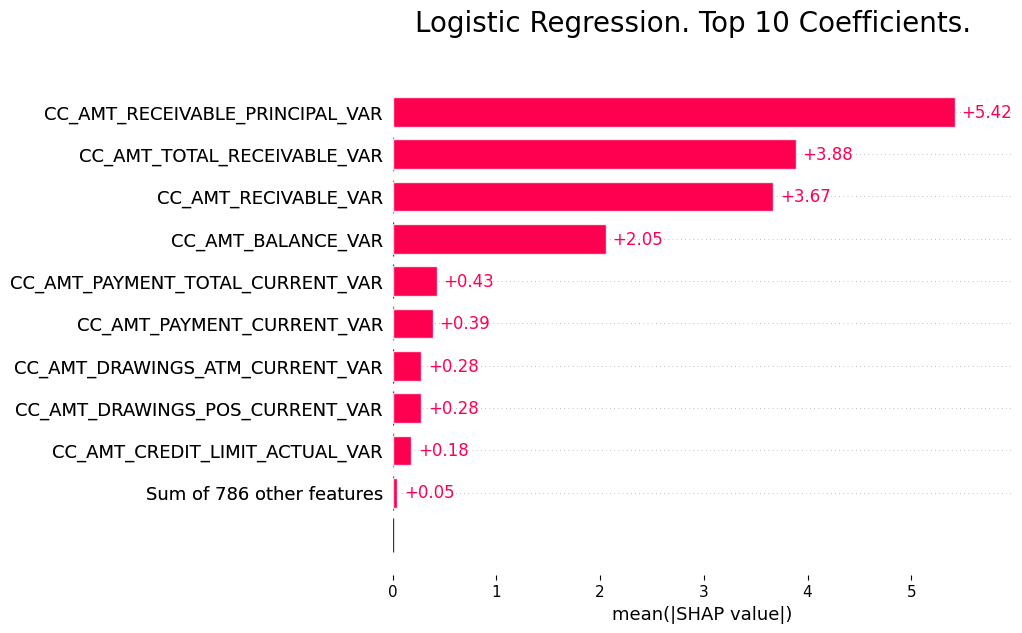

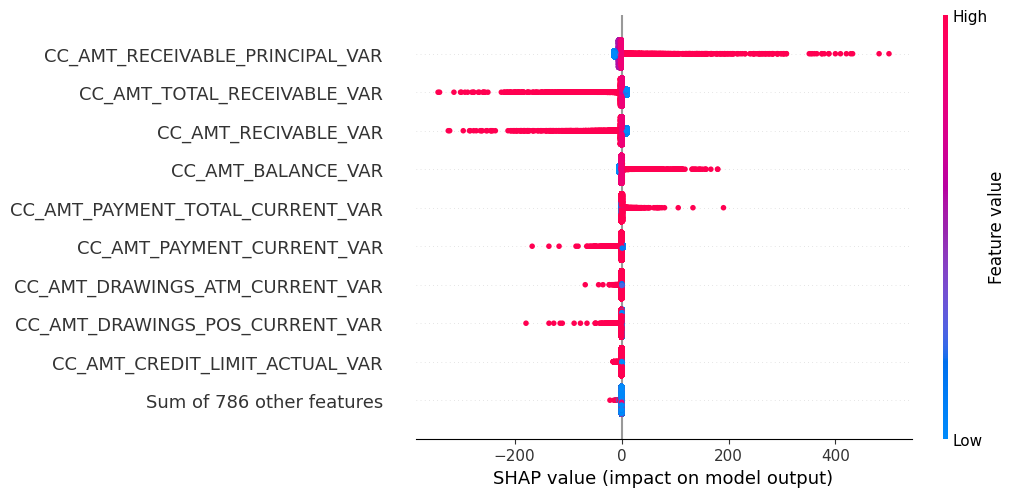

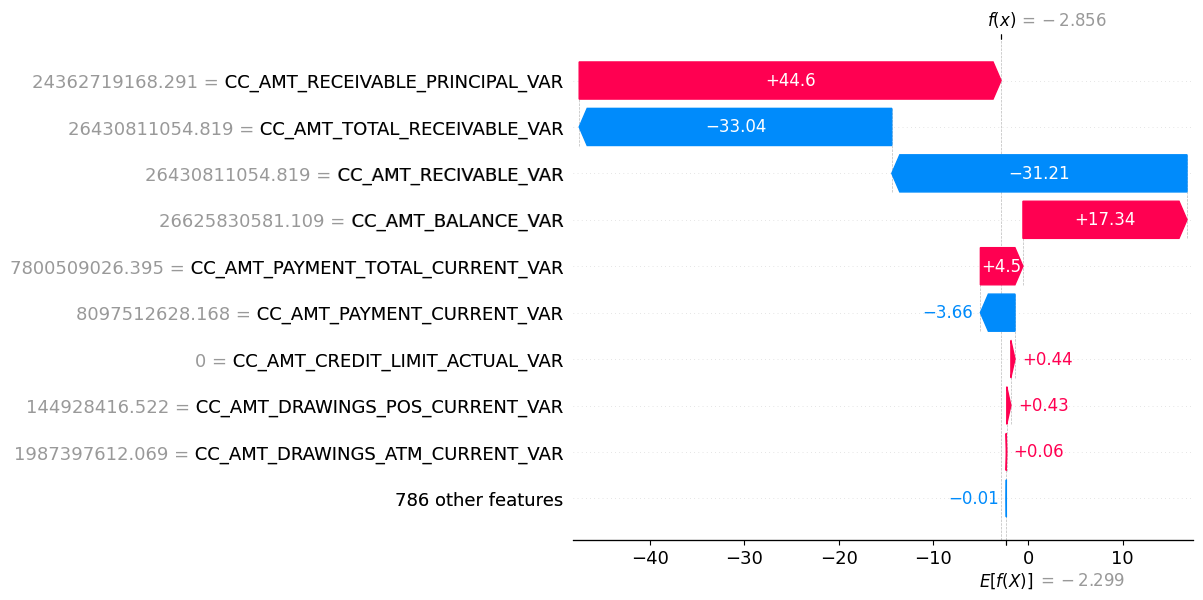

In [30]:
lin_explainer = shap.LinearExplainer(lr, train_x)

shap_values = lin_explainer(valid_x)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[50])

## With SMOTE

In [33]:
custom_scorer = make_scorer(custom_score_func, greater_is_better=False)

In [26]:
%%time

params = {
    "model__C":np.logspace(-3, 3, 7),
    "model__penalty":['l1', 'l2']
}

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
GS = GridSearchCV(pipeline, params, scoring=custom_scorer)

GS.fit(train_x, train_y)

print("tuned hpyerparameters :(best parameters) ",GS.best_params_)
print("accuracy :",GS.best_score_)
resultizeGrid(GS)

tuned hpyerparameters :(best parameters)  {'model__C': 0.1, 'model__penalty': 'l2'}
accuracy : 0.5428378930396589
CPU times: total: 2h 9min 58s
Wall time: 20min 58s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,mean_test_score,std_test_score,rank_test_score
5,28.622321,0.895671,0.100253,0.021438,0.1,l2,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.542838,0.005295,1
3,28.641622,0.560303,0.089079,0.000896,0.01,l2,"{'model__C': 0.01, 'model__penalty': 'l2'}",0.542785,0.005305,2
1,30.504242,2.452864,0.098817,0.027220,0.001,l2,"{'model__C': 0.001, 'model__penalty': 'l2'}",0.542779,0.005299,3
7,28.273185,0.437744,0.086561,0.009161,1.0,l2,"{'model__C': 1.0, 'model__penalty': 'l2'}",0.542776,0.005304,4
9,28.472134,0.227447,0.091282,0.001602,10.0,l2,"{'model__C': 10.0, 'model__penalty': 'l2'}",0.542767,0.005311,5
11,28.419918,0.593870,0.093084,0.005591,100.0,l2,"{'model__C': 100.0, 'model__penalty': 'l2'}",0.542767,0.005311,5
13,27.352317,0.355637,0.085876,0.005273,1000.0,l2,"{'model__C': 1000.0, 'model__penalty': 'l2'}",0.542767,0.005311,5
0,6.123075,0.147321,0.000000,0.000000,0.001,l1,"{'model__C': 0.001, 'model__penalty': 'l1'}",NaN,NaN,8
2,6.060966,0.238366,0.000000,0.000000,0.01,l1,"{'model__C': 0.01, 'model__penalty': 'l1'}",NaN,NaN,8
4,6.327820,0.302987,0.000000,0.000000,0.1,l1,"{'model__C': 0.1, 'model__penalty': 'l1'}",NaN,NaN,8


In [32]:
metrics = calcul_metrics(GS.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS.best_estimator_.predict(valid_x)))

logToMLflow(GS.best_estimator_, train_x, val_data, metrics, name="LogReg_Smote_GridSearch", params=GS.best_params_, training_tag="Basic LR model with SMOTE")

Précision : 0.80
AUC : 0.54
Score métier : 35873
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89     42452
         1.0       0.10      0.19      0.13      3675

    accuracy                           0.80     46127
   macro avg       0.51      0.52      0.51     46127
weighted avg       0.86      0.80      0.83     46127

CPU times: total: 1.09 s
Wall time: 7.73 s


<Axes: >

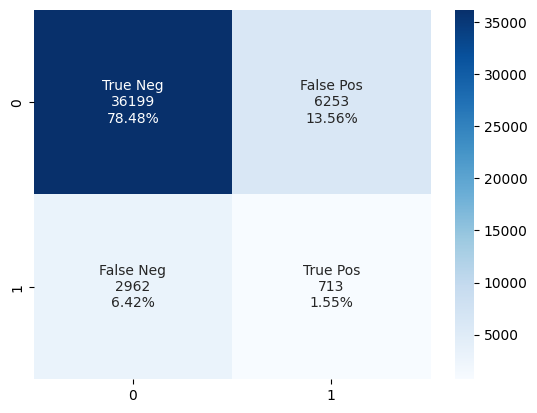

In [34]:
cf_matrix = confusion_matrix(valid_y, GS.best_estimator_.predict(valid_x))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

## Test custom scorer

In [34]:
train_x_30k = train_x[:30000]
train_y_30k = train_y[:30000]

In [35]:
%%time

params = {
    "model__C":np.logspace(-3, 3, 7)#,
    #"model__penalty":['l1', 'l2']
}



steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
GS2 = GridSearchCV(pipeline, params, scoring=custom_scorer)

GS2.fit(train_x_30k, train_y_30k)

print("tuned hpyerparameters :(best parameters) ",GS2.best_params_)
print("accuracy :",GS2.best_score_)
resultizeGrid(GS2)

tuned hpyerparameters :(best parameters)  {'model__C': 0.001}
accuracy : -4753.6
CPU times: total: 2min 15s
Wall time: 1min 51s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,mean_test_score,std_test_score,rank_test_score
0,3.260231,0.154659,0.012812,0.000400,0.001,{'model__C': 0.001},-4753.6,81.325519,1
5,3.070577,0.136724,0.012411,0.000490,100.0,{'model__C': 100.0},-4754.6,81.487668,2
6,2.938276,0.084453,0.012411,0.000490,1000.0,{'model__C': 1000.0},-4754.6,81.487668,2
4,2.973812,0.028222,0.012812,0.000749,10.0,{'model__C': 10.0},-4755.0,81.080207,4
1,3.047925,0.120340,0.012812,0.000400,0.01,{'model__C': 0.01},-4755.6,80.330816,5
2,3.061401,0.089073,0.012811,0.000400,0.1,{'model__C': 0.1},-4758.0,80.017498,6
3,2.997356,0.075536,0.012411,0.000490,1.0,{'model__C': 1.0},-4758.2,80.180796,7


In [37]:
metrics = calcul_metrics(GS2.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS2.best_estimator_.predict(valid_x)))

logToMLflow(GS2.best_estimator_, train_x, val_data, metrics, name="LogReg_Smote_GridSearch", params=GS2.best_params_, training_tag="Basic LR model with SMOTE")

Précision : 0.41
AUC : 0.54
Score métier : 38820
              precision    recall  f1-score   support

         0.0       0.93      0.38      0.54     42452
         1.0       0.08      0.66      0.15      3675

    accuracy                           0.41     46127
   macro avg       0.51      0.52      0.35     46127
weighted avg       0.86      0.41      0.51     46127



2024/02/01 16:21:03 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/01 16:21:03 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/01 16:21:06 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/01 16:21:06 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


# RandomForest

# XGBOOST

# LIGHTGBM